# Research Extention Notebook
The goal of this notebook is to be a template for research extention set of experiments.

* [Experiment name & other constants](#Set-constants)
* [Model architecture](#Model-architecture)
* [Predict on crops](#Predict-on-crops)
* [Show extention results](#Show-extention-results)

In [2]:
!nvidia-smi

Mon Feb 17 12:31:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   55C    P0    49W / 200W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 32%   56C    P0    49W / 200W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
# Necessary imports
%load_ext autoreload
%autoreload 2
import os
import sys
import logging

import json
import datetime
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import DenseNetFC, TFModel, EncoderDecoder
# from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb.batchflow.models.tf.layers import ConvBlock, aspp, combine
from seismiqb.batchflow.models.utils import unpack_args

from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset, plot_loss, show_extension_results, convert_to_numba_dict

from glob import glob
from tqdm import tqdm

from research_utils import notebook_path

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set constants

In [5]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [6]:
RESULTS_NAME = 'research'
RESULTS_PATH = RESULTS_NAME + '_from_' + datetime.datetime.today().strftime("%d-%m-%H.%M")
os.mkdir(RESULTS_PATH)

In [7]:
CUBES_PATH = ['/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5']
HORIZON_DIR = '/BEST_HORIZONS/*'

NUM_CROPS = 64
CROP_SHAPE = [2, 256, 256]
NUM_TEST_CROPS = 100
MICROBATCH = 8
EPOCHS = 1000
STRIDE = 10

# Load Dataset

In [8]:
dsi = FilesIndex(path=CUBES_PATH, no_ext=True)
ds = SeismicCubeset(dsi)
ds = ds.load(horizon_dir=HORIZON_DIR)

# Set train sampler

In [9]:
ds.modify_sampler('train_sampler', low=0.0, high=0.5, each=100, finish=True)
ds.modify_sampler('test_sampler', low=0.7, high=1.0, finish=True)

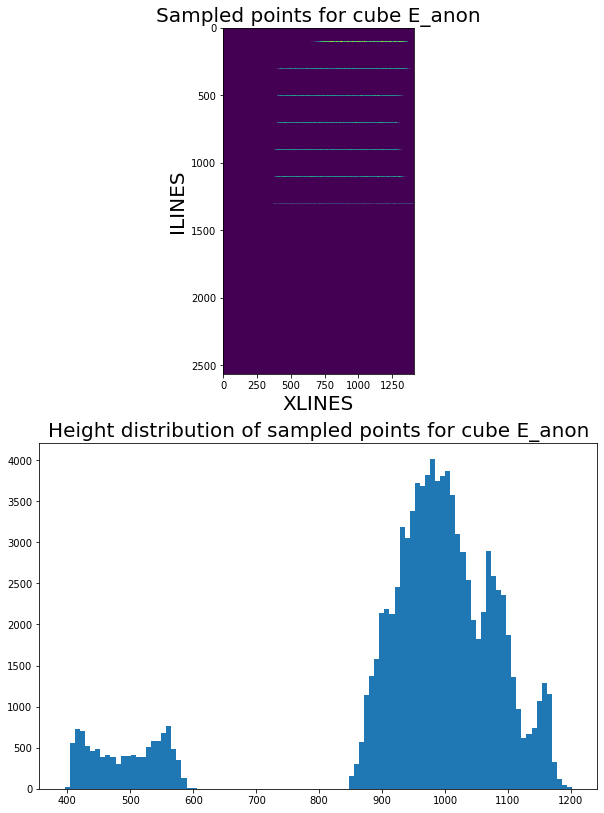

In [10]:
ds.show_sampler(src_sampler='train_sampler')

# Model architecture

In [11]:
class MyModel(EncoderDecoder):
    @classmethod
    def default_config(cls):
        config = TFModel.default_config()

        config['body/encoder'] = dict(base=None, num_stages=None,
                                      order=['skip', 'block', 'downsampling'])
        config['body/encoder/downsample'] = dict(layout='p', pool_size=2, pool_strides=2)
        config['body/encoder/blocks'] = dict(base=cls.block)

        config['body/embedding'] = dict(base=cls.block)

        config['body/decoder'] = dict(skip=True, num_stages=None, factor=None,
                                      order=['upsampling', 'block', 'combine'])
        config['body/decoder/upsample'] = dict(layout='tna')
        config['body/decoder/blocks'] = dict(base=cls.block, combine_op='concat')
        return config

    def build_config(self, names=None):
        config = super().build_config(names)
        config['common'].update(cut_masks=self.get_from_attr('cut_masks'))
        return config

    @classmethod
    def encoder(cls, inputs, name='encoder', **kwargs):
        base_class = kwargs.pop('base')
        order = cls.pop('order', kwargs)
        cut_masks = kwargs.pop('cut_masks')
        parallel = kwargs.pop('parallel')

        if base_class is not None:
            encoder_outputs = base_class.make_encoder(inputs, name=name, **kwargs)

        else:
            steps, downsample, block_args = cls.pop(['num_stages', 'downsample', 'blocks'], kwargs)
            order = ''.join([item[0] for item in order])

            base_block = block_args.get('base')
            with tf.variable_scope(name):
                x = inputs
                encoder_outputs = []

                y = cut_masks
                parallel_outputs = []

                for i in range(steps):
                    with tf.variable_scope('encoder-'+str(i)):
                        # Make all the args
                        args = {**kwargs, **block_args, **unpack_args(block_args, i, steps)}
                        if downsample:
                            downsample_args = {**kwargs, **downsample, **unpack_args(downsample, i, steps)}
                        for letter in order:
                            if letter == 'b':
                                x = ConvBlock(base_block=base_block, name='block', **args)(x)
                                if parallel:
                                    y = ConvBlock(base_block=base_block, name='parallel_block', **args)(y)                                                                
                                    x_att = combine((y, x), op='attention', data_format=args['data_format'])

                                    with tf.variable_scope('second_attention'):
                                        y_att = combine((x, y), op='attention', data_format=args['data_format'])
                                    x = x_att
                                    y = y_att
                                else:
                                    y = ConvBlock(base_block=base_block, name='parallel_block', **args)(y)
                                    x = combine((x, y), op='sum')
                                    
                            elif letter == 's':
                                encoder_outputs.append(x)

#                                 parallel_outputs.append(y)
                            elif letter in ['d', 'p']:
                                if downsample.get('layout') is not None:
                                    x = ConvBlock(name='downsample', **downsample_args)(x)
                                    y = ConvBlock(name='parallel_downsample', **downsample_args)(y)
                            else:
                                raise ValueError('Unknown letter in order {}, use one of "b", "d", "p", "s"'
                                                 .format(letter))
                encoder_outputs.append(x)
        return encoder_outputs

    @classmethod
    def head(cls, inputs, targets, name='head', **kwargs):
        kwargs = cls.fill_params('head', **kwargs)
        with tf.variable_scope(name):
            x = TFModel.head(inputs, name, **kwargs)
#             channels = cls.num_channels(targets)
            channels = CROP_SHAPE[0]
            args = {**kwargs, **dict(layout='ca', kernel_size=1, activation=tf.nn.sigmoid, filters=channels)}
            x = ConvBlock(name='conv1x1', **args)(x)
            if cls.num_channels(x) != channels:                
                args = {**kwargs, **dict(layout='ca', kernel_size=1, activation=tf.nn.sigmoid, filters=channels)}
                x = ConvBlock(name='conv1x1', **args)(x)
                x = tf.expand_dims(x, axis=-1, name='expand')
        return x

# Loss

In [14]:
K = tf.keras.backend

def tversky(y_true, y_pred):
    print('y true', y_true.get_shape().as_list())
    print('y_pred', y_pred.get_shape().as_list())

    smooth = 1.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.5
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    loss = 1 - tversky(y_true,y_pred)
    print('Tversky Loss is: {}'.format(loss))
    return loss

# Config

In [15]:
MODEL_SHAPE = [CROP_SHAPE[i] for i in(1, 2, 0)]

model_config_base = {'initial_block/inputs': 'images',
                    'body/encoder': {'num_stages': 3,
                                     'blocks': {
                                               'filters': [32, 64, 128]}},
                    'body/decoder': {'order': ['c', 'b'],
                                     'combine': {'op':'gau', 'filters': [128, 64, 32]},
                                     'num_stages': 3,
                                     'upsample': {'layout': 'tna',
                                                   'kernel_size': 2,},
                                     'blocks': {'filters': [128, 64, 32]}},
                    'loss': {'name': tversky_loss, 'add_loss': True},
                    'optimizer': {'name':'Adam', 'learning_rate': 5 * 1e-3},
                    'body/encoder/parallel': False,
                    'output': 'sigmoid',
                    'common': {'data_format': 'channels_last'},
                    'inputs/images/shape': MODEL_SHAPE,
                    'inputs/masks/shape': MODEL_SHAPE,
                    'inputs/cut_masks/shape': MODEL_SHAPE,
                    'microbatch': MICROBATCH,
                    }

# Training

In [16]:
train_pipeline = (Pipeline()
            .crop(points=D('train_sampler')(NUM_CROPS), shape=CROP_SHAPE)
            .load_cubes(dst='images')
            .create_masks(dst='masks', width=2, n_horizons=1)
            .rotate_axes(src=['images', 'masks'])
            .scale(mode='normalize', src='images')
            .filter_out(src='masks', dst='cut_masks',
                        expr=lambda m: m[:, 0],
                        low=P(R('uniform', low=0.1,high=0.4)),
                        length=P(R('uniform', low=0.20, high=0.6)))
            .call(lambda x: np.array([item.astype('float') for item in x.cut_masks]), save_to=B('cut_masks'))
            .init_variables(dict(loss_history=dict(default=[]),
                                 ext_loss_history=dict(default=[])))
            .init_model('dynamic', MyModel, 'base', model_config_base)
            .train_model('base', fetches='loss',
                         images=B('images'), masks=B('masks'), cut_masks=B('cut_masks'),
                         save_to=V('loss_history', mode='a')))  << ds

In [ ]:
EPOCHS = 1500
train_pipeline.run(D('size'), n_iters=EPOCHS, bar=True)

  0%|          | 0/1500 [00:00<?, ?it/s]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
y true [None, 256, 256, 2]
y_pred [None, 256, 256, 2]
Tversky Loss is: Tensor("MyModel/device_GPU_0_1/sub_2:0", shape=(), dtype=float32, device=/device:GPU:0)


  3%|▎         | 45/1500 [02:30<55:57,  2.31s/it]  

# Plot loss history

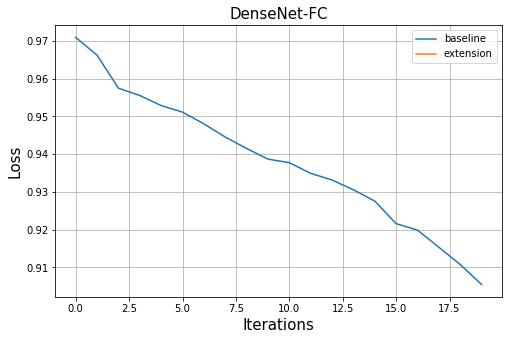

In [119]:
plot_loss([train_pipeline.v('loss_history'), train_pipeline.v('ext_loss_history')],
          ['baseline', 'extension'], ylabel='Loss', title='DenseNet-FC')

In [17]:
loss_path = os.path.join(RESULTS_PATH, 'training_loss.npy')

In [121]:
np.save(loss_path, np.array(train_pipeline.v('loss_history')))

# Save model

In [16]:
model_path = os.path.join(RESULTS_PATH, 'saved_model')

In [126]:
train_pipeline.m('base').save(model_path)

In [127]:
config_dict = dict(model_config_base)

In [128]:
config_dict.pop('loss')

{'name': <function __main__.tversky_loss(y_true, y_pred)>, 'add_loss': True}

In [18]:
config_path = os.path.join(RESULTS_PATH, 'model_config.json')

In [131]:
with open(config_path, 'w') as fp:
    json.dump(config_dict, fp)

# Predict on crops

### Test on the same cubes

Define `test_pipeline` that imports models from `train_pipeline` and runs `predict_model`

In [21]:
test_pipeline = (Pipeline()
                 .crop(points=D('test_sampler')(NUM_CROPS), shape=CROP_SHAPE)
                 .load_cubes(dst='images')
                 .create_masks(dst='masks', width=2, n_horizons=1)
                 .rotate_axes(src=['images', 'masks'])
                 .scale(mode='normalize', src='images')
                 .filter_out(src='masks', dst='cut_masks',
                             expr=lambda m: m[:, 0],
                             low=P(R('uniform', low=0.3,high=0.4)),
                             high=P(R('uniform', low=0.40, high=0.45)))
                 .import_model('base', train_pipeline)
                 .init_variable('result', [])
                 .call(lambda x: np.array([item.astype('float') for item in x.cut_masks]), save_to=B('cut_masks'))
                 .predict_model('base',
                                fetches=['images', 'masks', 'predictions', 'loss', 'cut_masks'],
                                images=B('images'), cut_masks=B('cut_masks'), masks=B('masks'),
                                save_to=V('result'))
                 .import_model('extension', train_pipeline)
                 .init_variable('ext_result', [])
                 .concat_components(src=('images', 'cut_masks'), dst='model_inputs')
                 .predict_model('extension',
                                fetches=['images', 'masks', 'predictions', 'loss', 'cut_masks'],
                                images=B('images'), cut_masks=B('cut_masks'), masks=B('masks'),
                                save_to=V('ext_result'))) << ds

Loss is:  0.9721596
E_anon


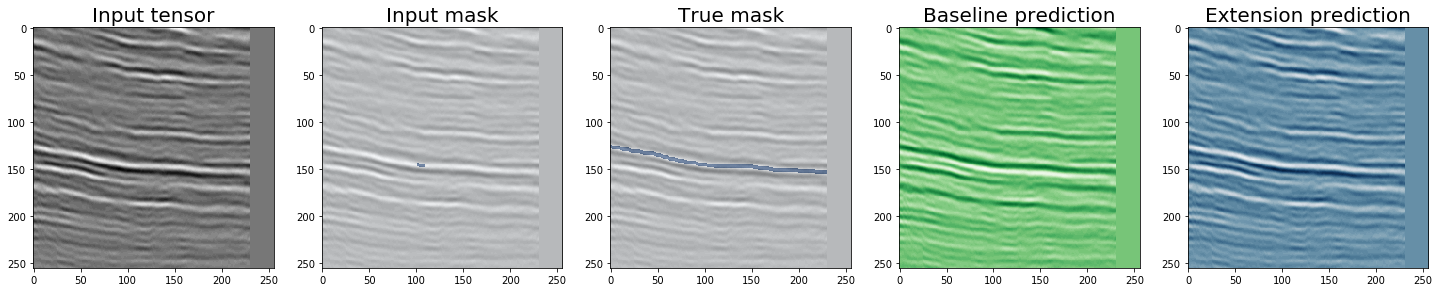

E_anon


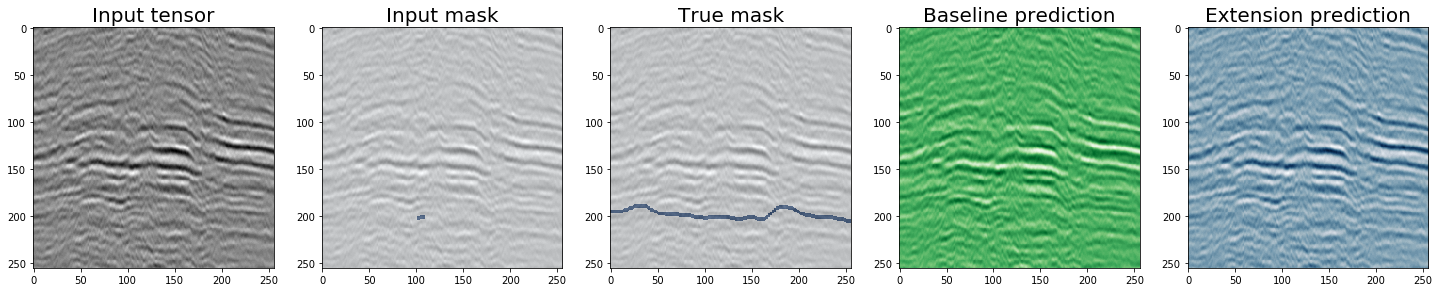

E_anon


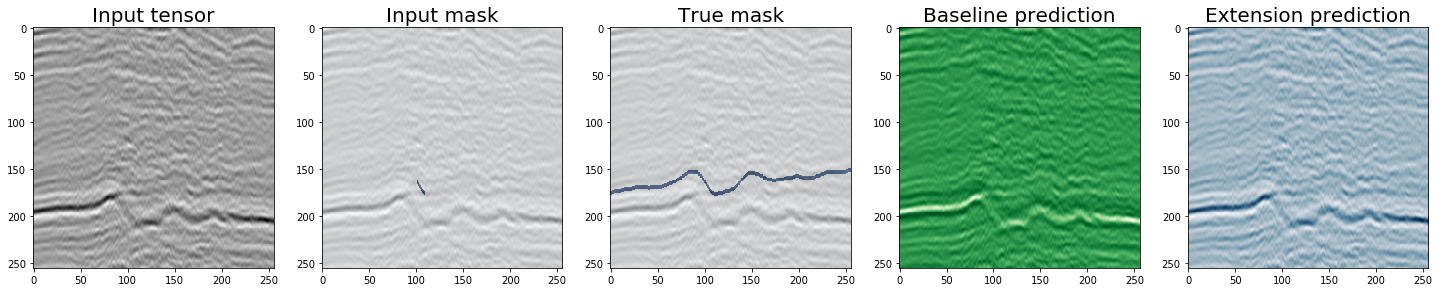

E_anon


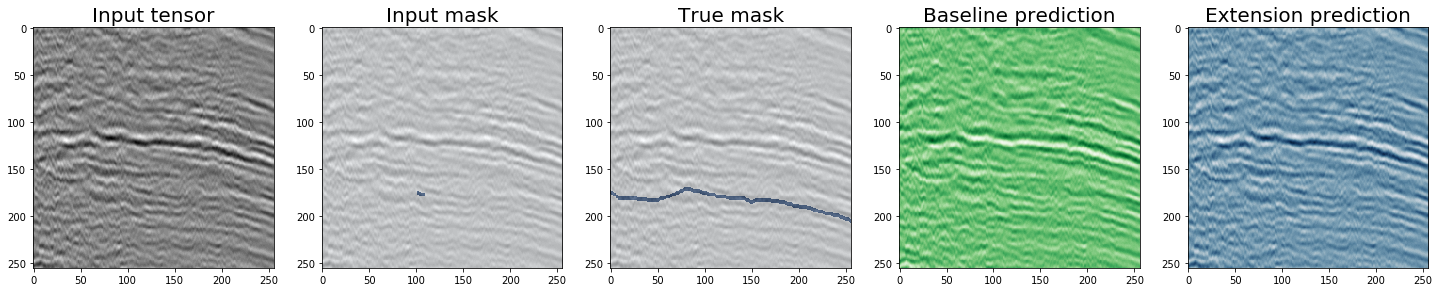

E_anon


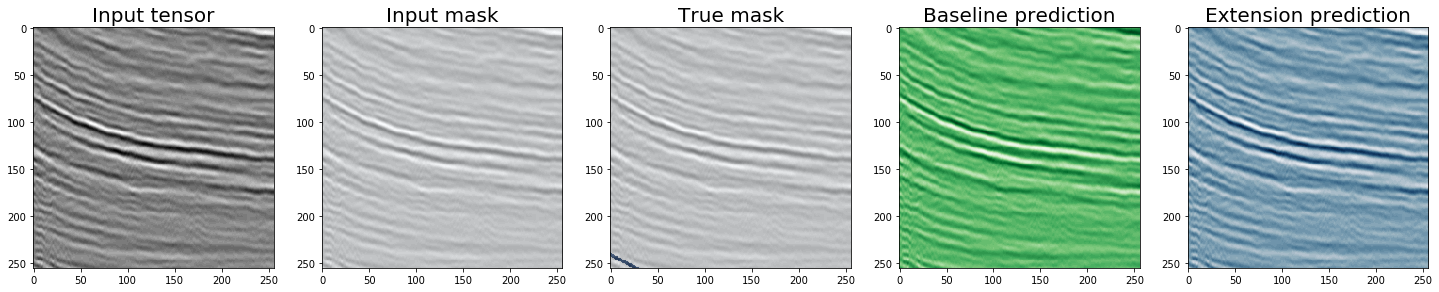

E_anon


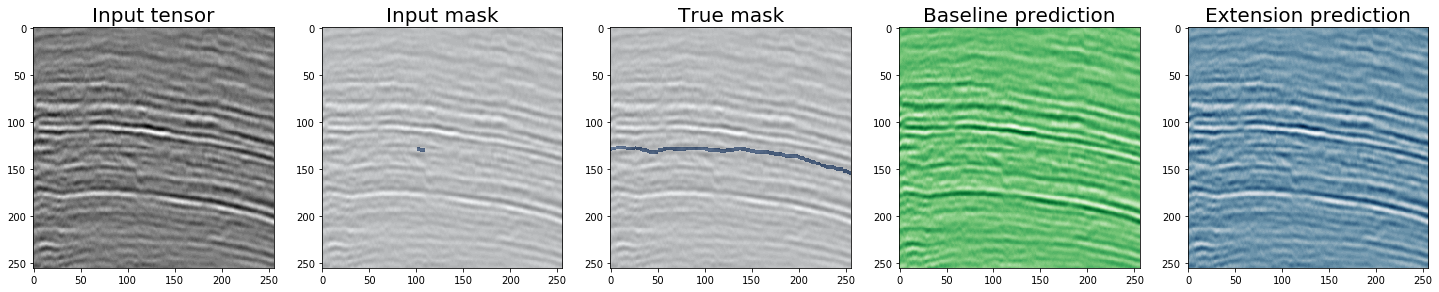

E_anon


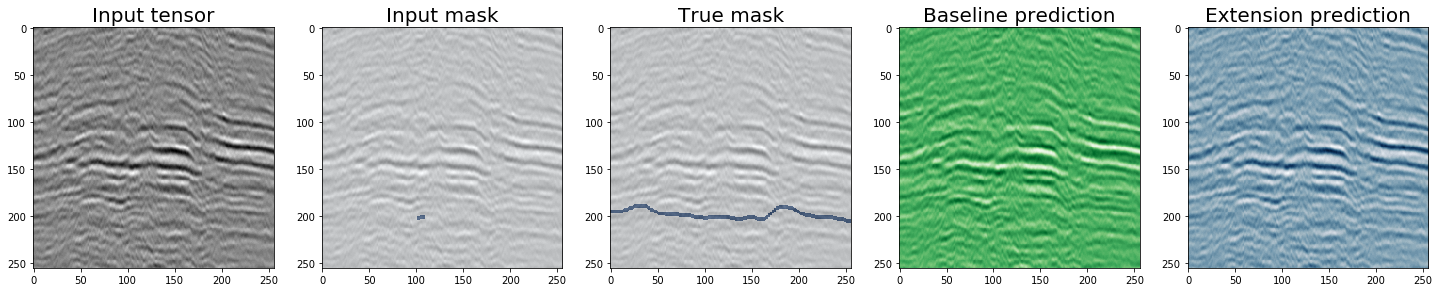

E_anon


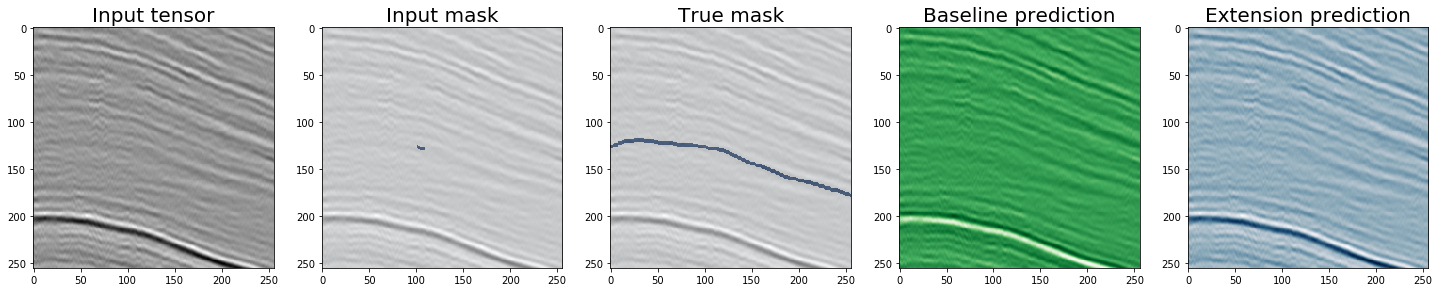

E_anon


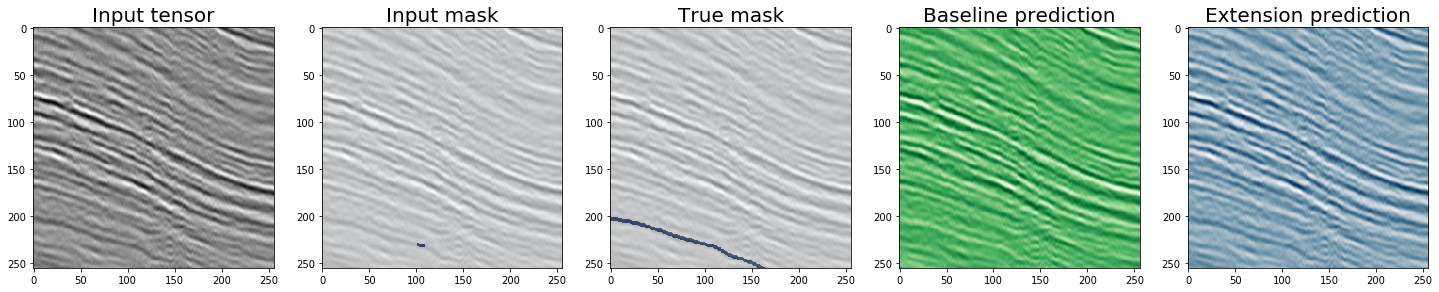

E_anon


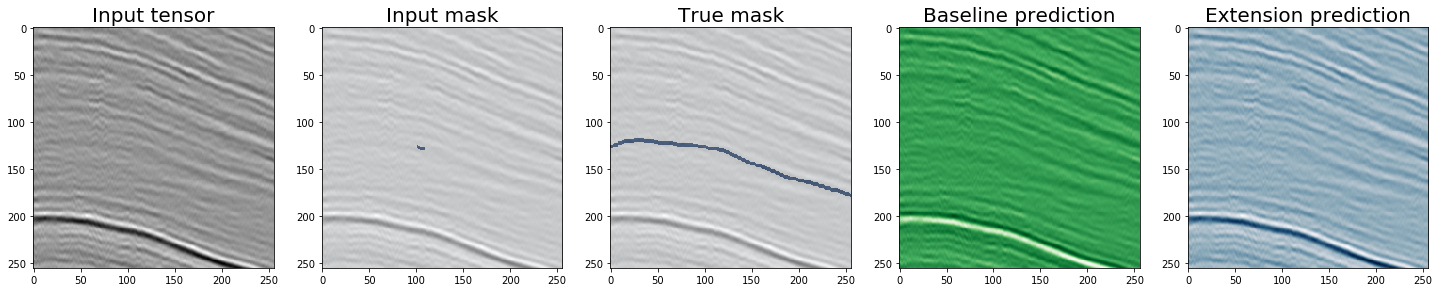

In [23]:
test_batch = test_pipeline.next_batch(1, n_epochs=None)

cubes_numbers = np.random.choice(NUM_CROPS, 10)
print('Loss is: ', test_pipeline.get_variable('ext_result')[3])
show_extension_results(test_batch, test_pipeline, cubes_numbers, baseline_result='result')

# In the big picture

In [7]:
predict_pipeline = (Pipeline()
                     .load_model('static', TFModel, 'extension', path='./pseudoattention/') << ds)

predict_pipeline.next_batch(1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./pseudoattention/model-1022


In [11]:
test_ds = ds
axes = (0, 1, 2)

In [9]:
def create_predict_ppl(test_ds, predict_pipeline, crop_shape, stride=10):
    predict_ppl = (Pipeline()
                   .generate_point(stride=stride, shape=crop_shape, dst='next_point')
                   .crop(points=B('next_point'), shape=crop_shape, passdown='predicted_labels')
                   .load_cubes(dst='images')
                   .create_masks(dst='cut_masks', width=1, n_horizons=1, src_labels='predicted_labels')
                   .apply_transform(np.transpose, axes=axes, src=['images', 'cut_masks'])
                   .rotate_axes(src=['images', 'cut_masks'])
                   .scale(mode='normalize', src='images')
                   .import_model('extension', predict_pipeline)
                   .init_variable('result_preds', init_on_each_run=list())
                   .predict_model('extension', fetches='sigmoid',
                                  images=B('images'), cut_masks=B('cut_masks'),
                                  save_to=B('predictions'))
                   .call(lambda x: np.moveaxis(np.stack([x.predictions[..., 0, 0],
                                                         x.predictions[..., 0, 0]], axis=-1), -1, 1), save_to=B('predictions'))
                   .get_point_cloud(src_masks='predictions', dst='batch_predicted_labels', n_workers=1,
                                    coordinates='lines')
                   .merge_point_clouds(src='batch_predicted_labels', dst='predicted_labels')
                   .create_masks(dst='predicted_masks_from_dict', width=1, n_horizons=1, src_labels='predicted_labels')
                  ) << test_ds
    return predict_ppl

# Show extention results

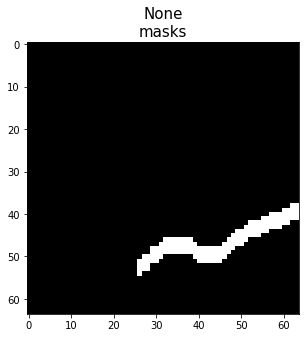

final predicted_labels length 1568


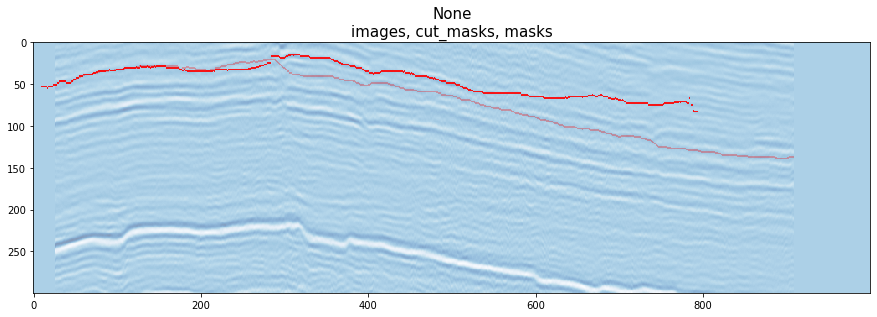

Average value of l1 is 18.496740547588004


Average value of ~ is 0.4661016949152542


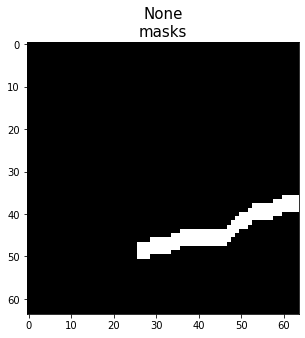

final predicted_labels length 1776


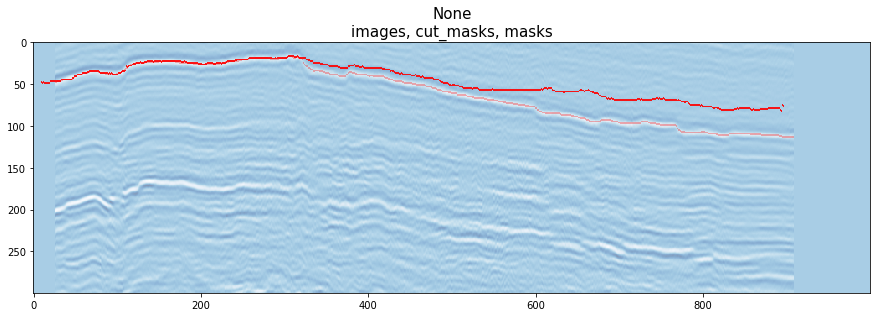

Average value of l1 is 13.96670493685419


Average value of ~ is 0.3949483352468427


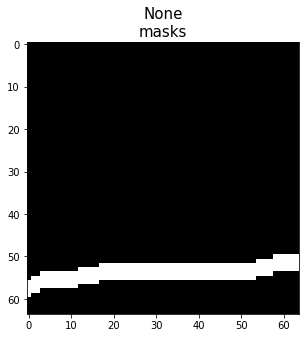

final predicted_labels length 1500


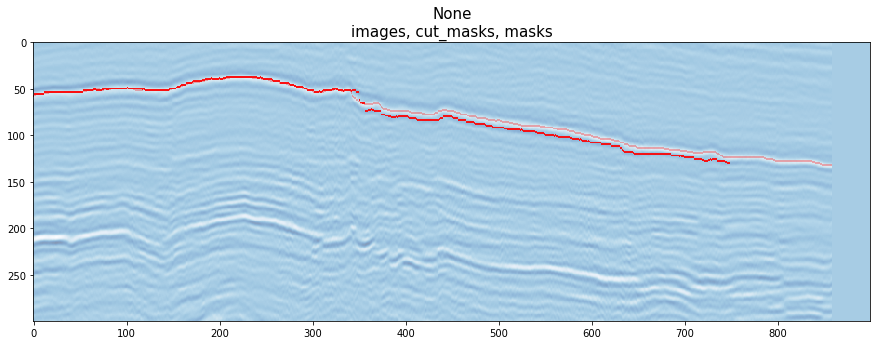

Average value of l1 is 3.7546666666666666


Average value of ~ is 0.3453333333333333


In [12]:
MAX_ITERS = 2000

TEST_POINTS = [[641, 381, 850], [641, 381, 1050], [741, 431, 1040]]
HOR_INDICES = [2, 0, 0]
SLICE_SHAPES = [[2, 1000, 300], [2, 1000, 300], [2, 900, 300]]

crop_shape = [2, 64, 64]

img_paths = []
metrics = []

for j, p_start_points in enumerate(TEST_POINTS):
    HOR_IDX = HOR_INDICES[j]
    SLICE_SHAPE = SLICE_SHAPES[j]
    test_ds.subset_labels(p_start_points, crop_shape=crop_shape, cube_index=0, show_prior_mask=True,
                          n_horizons=[HOR_IDX], figsize=(5, 5),
                          dst='predicted_labels')


    predict_ppl = create_predict_ppl(test_ds, predict_pipeline, crop_shape=crop_shape, stride=STRIDE)
    for i in (range(MAX_ITERS)):
        old_len = len(test_ds.predicted_labels[test_ds.indices[0]])
        test_batch = predict_ppl.next_batch(1, n_epochs=None)
        if len(test_ds.predicted_labels[test_ds.indices[0]]) == old_len:
            print('final predicted_labels length', old_len)
            break
        ## Also add stop condition on the end of cube
        elif(test_batch.slices[0][1][-1] + STRIDE > test_ds.geometries[test_ds.indices[0]].xlines_len):
            break

    ar_p_start_points = np.array([test_ds.indices[0], *p_start_points], dtype=np.object).reshape(1, -1)
    img_path = os.path.join(RESULTS_PATH,
                            'crop_{}_cube_{}.png'.format(p_start_points, test_ds.indices[0])).replace(' ', '')

    show_ppl = (Pipeline()
                   .crop(points=ar_p_start_points, shape=SLICE_SHAPE, passdown='predicted_labels')
                   .load_cubes(dst='images')
                   .create_masks(dst='cut_masks', width=1, n_horizons=1, src_labels='predicted_labels')
                   .create_masks(dst='masks', width=1, n_horizons=[HOR_IDX], src_labels='labels')
                   .apply_transform(np.transpose, axes=axes, src=['images', 'masks', 'cut_masks'])
                   .rotate_axes(src=['images', 'masks', 'cut_masks'])
                   .scale(mode='normalize', src='images')) << test_ds
    results_batch = show_ppl.next_batch(1)

    ## ADD right horizon idx
    results_batch.plot_components('images', 'cut_masks', 'masks', alphas=[0.5, 0.9, 0.3],
                                  cmaps=['Blues', 'Blues', 'Greens'],
                                  savefig=img_path)
    img_paths.append(img_path)
    metric_1, metric_2, indicator = test_ds.compare_horizons(test_ds.predicted_labels[test_ds.indices[0]],
                                                             test_ds.labels[test_ds.indices[0]],
                                                             hor_1_idx=0, hor_2_idx=HOR_IDX, _return=True, show_plot=False)
    l1 = np.round(np.mean(metric_1[np.where(indicator == 0)]), 3)
    metrics.append(l1)

# Dump experiment's results

In [13]:
current_nb_path = notebook_path()

In [14]:
crop_shape

[2, 64, 64]

In [19]:
col_names = ['name', 'model_path', 'crop_shape', 'nb_path', 'config_path', 'loss_path', 'img_path', 'l1']
log = pd.DataFrame(np.array([RESULTS_PATH, model_path, crop_shape, current_nb_path, config_path,
                             loss_path, img_paths, metrics]).reshape(1, -1), columns=col_names)
log

name                             model_path  \
0  research_from_17-02-12.21  research_from_17-02-12.21/saved_model   

    crop_shape                                            nb_path  \
0  [2, 64, 64]  /notebooks/darima/dev/gpn/seismiqb/models/note...   

                                   config_path  \
0  research_from_17-02-12.21/model_config.json   

                                     loss_path  \
0  research_from_17-02-12.21/training_loss.npy   

                                            img_path                       l1  
0  [research_from_17-02-12.21/crop_[641,381,850]_...  [18.497, 13.967, 3.755]

In [20]:
if os.path.exists('experiments_log.csv'):
    previous_log = pd.read_csv('experiments_log.csv', names=col_names, skiprows=1)
    pd.concat([previous_log, log], ignore_index=True).to_csv('experiments_log.csv')
else:
    log.to_csv('experiments_log.csv')

In [21]:
pd.read_csv('experiments_log.csv')

Unnamed: 0                       name  \
0           0  research_from_17-02-08.39   
1           1  research_from_17-02-12.21   

                              model_path   crop_shape  \
0  research_from_17-02-08.39/saved_model  [2, 64, 64]   
1  research_from_17-02-12.21/saved_model  [2, 64, 64]   

                                             nb_path  \
0  /notebooks/darima/dev/gpn/seismiqb/models/note...   
1  /notebooks/darima/dev/gpn/seismiqb/models/note...   

                                   config_path  \
0  research_from_17-02-08.39/model_config.json   
1  research_from_17-02-12.21/model_config.json   

                                     loss_path  \
0  research_from_17-02-08.39/training_loss.npy   
1  research_from_17-02-12.21/training_loss.npy   

                                            img_path                       l1  
0  ['research_from_17-02-08.39/crop_[641,381,850]...  [17.721, 13.967, 3.755]  
1  ['research_from_17-02-12.21/crop_[641,381,850]...  [18.497, 13.967, 3.755]